In [1]:
import warnings
#warnings.filterwarnings("error")
import os, sys
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from fnmatch import fnmatch

In [2]:
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2022-09-13 10:22:32.209397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:22:32.209787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:22:32.253121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:22:32.253410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:22:32.253657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/l/projects/Morpheus/Tutorial/BayesFlow/bayesflow/trainers.py:16: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
import time
import glob
import subprocess

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
RNG = np.random.default_rng(2022)

In [7]:
def model_prior():
    DV = RNG.choice([0,0.2,0.4,0.6,0.8,1])
    bcf = RNG.uniform(low=0.01,high=1)
    pi = RNG.uniform(low=0.01,high=1)
    cv = RNG.uniform(low=0.01,high=1)
    return np.array([DV, bcf, pi, cv])

In [8]:
models = "trained_models"
param_nr = len(model_prior())
summary_parm = 64
inn_layer = 8
data_path = '/home/l/projects/Morpheus/Modelle/cell_free_50'
timesteps = 50
cut_off_start = 9
cut_off_end = 10
checkpoint_path=os.path.abspath(os.path.join(os.getcwd(), models,"summary_more_power_offline_short_DV" + "_pr-" + str(param_nr) + "_sr-" +  str(summary_parm) + "_inn_layer-" + str(inn_layer) + "_" + '_ts-' + str(timesteps) + datetime.now(tz=None).strftime("%Y%m%d_%H:%M:%S")))

In [9]:
def calculate_V(path: str):
    df = pd.read_csv(path,sep='\t')
    df = df[df["10"]!=10]
    morpheus_ts = np.repeat(range(0,timesteps+1),10)
    times = np.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    if len(times) != len(df.index):
        print(path)
    df["time"] = np.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    df['sum_V'] = df.iloc[:, 1:11].sum(axis=1)
    df = df.drop(columns=[str(x) for x in range(0,11)])
    df = df.groupby(list(df.columns[:-1])).agg({'sum_V': 'sum'}).reset_index()
    return np.expand_dims(df['sum_V'],axis=1)[cut_off_start+1:timesteps-cut_off_end]

In [10]:
prior = Prior(prior_fun=model_prior, param_names=[r'DV',r'bcf',r'pi',r'cv'])

In [11]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [12]:
from os import getcwd


def run_morpheus(params):
    DV, bcf, pi, cv  = params

    model_dir='model'
    model_pattern = os.path.join(data_path, model_dir, '*DV-%s*.xml' % DV)
    models = glob.glob(model_pattern)
    model = models[0]

    OUT=os.path.join(data_path, 'output_DV_online', 'DV-' + str(DV) + '_bcf-' + str(bcf) + '_'  + 'pi-' +  str(pi) + '_' + 'cv-' + str(cv))
    print(OUT)
    !mkdir "$OUT"
    !morpheus -f "$model" -o "$OUT" -b_cf="$bcf" -c_V="$cv" -p_V="$pi"
    
    final_plot = os.path.join(OUT,'plot-1_' + str(timesteps).zfill(5) + '.png')
    while not os.path.exists(final_plot):
        time.sleep(1)
    
    population_file = os.path.join(OUT,'logger_2.csv')
    df = pd.read_csv(population_file, sep='\t')
    df_tar = df['celltype.target.size'].values[:, np.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_inf = df['celltype.infected.size'].values[:, np.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_cells = np.append(df_tar,df_inf,axis=1)

    v_path = os.path.join(OUT,"logger_6_Ve.csv")
    v = calculate_V(v_path)
    sim = np.append(df_cells, v, axis=1)

    return sim

In [13]:
run_morpheus([1,1,1,0])

/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-1_bcf-1_pi-1_cv-0
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-1_bcf-1_pi-1_cv-0“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-1_bcf-1_pi-1_cv-0
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-1_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1663057353
Random seed of thread 3 = 5109613
Random seed of thread 9 = 8374347
Random seed of thread 1 = 6434821
Random seed of thread 12 = 2380986
Random seed of thread 13 = 1312361
Random seed of thread 7 = 3706792
Random seed of thread 4 = 6294588
Random seed of thread 15 = 1520457
Random seed of thread 2 = 6046806
Random seed of thread 14 = 7999582
Random seed of thread 8

array([[4.900e+01, 1.000e+00, 0.000e+00],
       [4.900e+01, 1.000e+00, 0.000e+00],
       [4.500e+01, 5.000e+00, 1.000e+00],
       [3.400e+01, 1.600e+01, 1.000e+01],
       [1.700e+01, 3.300e+01, 3.900e+01],
       [5.000e+00, 4.500e+01, 1.000e+02],
       [0.000e+00, 5.000e+01, 1.860e+02],
       [0.000e+00, 5.000e+01, 2.770e+02],
       [0.000e+00, 5.000e+01, 3.680e+02],
       [0.000e+00, 5.000e+01, 4.590e+02],
       [0.000e+00, 5.000e+01, 5.500e+02],
       [0.000e+00, 5.000e+01, 6.410e+02],
       [0.000e+00, 5.000e+01, 7.320e+02],
       [0.000e+00, 5.000e+01, 8.230e+02],
       [0.000e+00, 5.000e+01, 9.140e+02],
       [0.000e+00, 5.000e+01, 1.005e+03],
       [0.000e+00, 5.000e+01, 1.096e+03],
       [0.000e+00, 5.000e+01, 1.187e+03],
       [0.000e+00, 5.000e+01, 1.278e+03],
       [0.000e+00, 5.000e+01, 1.369e+03],
       [0.000e+00, 5.000e+01, 1.460e+03],
       [0.000e+00, 5.000e+01, 1.551e+03],
       [0.000e+00, 5.000e+01, 1.642e+03],
       [0.000e+00, 5.000e+01, 1.73

In [14]:
simulator = Simulator(simulator_fun=partial(run_morpheus))

In [15]:
model = GenerativeModel(prior, simulator, name='morpheus')

/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.6_bcf-0.521442394009141_pi-0.3650127693248505_cv-0.6972942864361873
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.6_bcf-0.521442394009141_pi-0.3650127693248505_cv-0.6972942864361873“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.6_bcf-0.521442394009141_pi-0.3650127693248505_cv-0.6972942864361873
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.6_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1663057356
Random seed of thread 15 = 9650768
Random seed of thread 11 = 3756151
Random seed of thread 3 = 8846725
Random seed of thread 13 = 8017828
Random seed of thread 7 = 5240809
Random seed of thread 14 = 422022
Ra

INFO:root:Performing 2 pilot runs with the morpheus model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 30, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [16]:
path_list= glob.glob(os.path.join(data_path, "output_DV_online/*"))
nr_of_params = param_nr

n_sim = len(path_list)
dfs = np.empty((n_sim, (timesteps - 1 - cut_off_start - cut_off_end), 3), dtype=np.float32)
params = np.empty((n_sim, nr_of_params), dtype=np.float32)
invalidIndices = []

for path in range(n_sim):
    pathname = path_list[path]
    filename = os.path.join(pathname,'logger_2.csv')
    filename_V = os.path.join(pathname, 'logger_6_Ve.csv')
    df = pd.read_csv(filename, index_col=None, header=0, delimiter='\t')
    path_split = filename.split('/')[len(filename.split('/')) - 2]
    if path_split.startswith('sweep'):
        start_nr = 1
    else:
        start_nr = 0
    params_split = path_split.split('_')[start_nr:nr_of_params+1]
    param_file = list(map(lambda x: round(float(x.split('-')[1]),3), params_split))
    
    df_tar = df['celltype.target.size'].values[:, np.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_inf = df['celltype.infected.size'].values[:, np.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_cells = np.append(df_tar,df_inf,axis=1)
    df_V = calculate_V(filename_V)

    if np.any(df_inf<1) or np.any(np.asarray(param_file)>1) or len(df_inf) != (timesteps - 1 - cut_off_start - cut_off_end):
        invalidIndices.append(path)
        continue
    params[path] = param_file
    dfs[path] = np.append(df_cells,df_V,axis=1)
    
    #dfs[path] = df_inf[cut_off_start+1:timesteps-cut_off_end]
dfs = np.delete(dfs, invalidIndices, axis=0)
params = np.delete(params, invalidIndices, axis=0)    

In [17]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, n_summary):
        super(ConvLSTM, self).__init__()

        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=3, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu')
        ])
        
    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""
        out = self.conv(x)
        out = self.lstm(out)
        out = self.dense(out)

        return out

In [18]:
summary_net = ConvLSTM(n_summary=summary_parm)

2022-09-13 10:25:03.747873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 10:25:03.993202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:25:03.993533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:25:03.993764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
inference_net = InvertibleNetwork({
    'n_params': param_nr, 
    'n_coupling_layers': inn_layer, 
})

In [20]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='covid_amortizer')

In [21]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {} 
    
    # Convert data to logscale 
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        logdata = np.log1p(forward_dict['sim_data']).astype(np.float64)
        
        for w in wlist:
            np.set_printoptions(threshold=np.inf)
            print('Parameters', '\n')
            print(forward_dict['prior_draws'], '\n')
            print('Simulation', '\n')
            print(forward_dict['sim_data'], '\n')
            
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float64)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    #idx_keep = np.all(np.isfinite(logdata), axis=0)
    #if not np.all(idx_keep):
    #    print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata
    out_dict['parameters'] = params
    #out_dict['summary_conditions'] = logdata[idx_keep]
    #out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [22]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input,
                  checkpoint_path=checkpoint_path
                  )

INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...


/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.0_bcf-0.1793313480334252_pi-0.7817278115282552_cv-0.3807064973584186
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.0_bcf-0.1793313480334252_pi-0.7817278115282552_cv-0.3807064973584186“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Modelle/cell_free_50/output_DV_online/DV-0.0_bcf-0.1793313480334252_pi-0.7817278115282552_cv-0.3807064973584186
Initializing from file /home/l/projects/Morpheus/Modelle/cell_free_50/model/cell_free_50_DV-0.0_30_8.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1663057505
Random seed of thread 6 = 551484
Random seed of thread 12 = 3249004
Random seed of thread 14 = 8910832
Random seed of thread 15 = 9768055
Random seed of thread 2 = 1769538
Random seed of thread 5 = 7377256


2022-09-13 10:25:10.975404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-13 10:25:11.684640: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
INFO:root:Done.


In [23]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 274624    
 bleNetwork)                                                     
                                                                 
 conv_lstm (ConvLSTM)        multiple                  124288    
                                                                 
Total params: 398,912
Trainable params: 398,848
Non-trainable params: 64
_________________________________________________________________


In [24]:
%%time
h = trainer.train_offline(epochs=10, batch_size=16, simulations_dict = { "prior_draws": params, "sim_data" : dfs })
#h = trainer.train_rounds(rounds=20, sim_per_round=10, epochs=100, batch_size=16)

Training epoch 10: 100%|██████████| 1581/1581 [04:57<00:00,  5.32it/s, Epoch: 10, Batch: 1580,Loss: -3.301,Avg.Loss: -2.681,L.Slope: 0.008] 


CPU times: user 49min 49s, sys: 15.4 s, total: 50min 4s
Wall time: 49min 31s


In [25]:
h

,Default.Loss
0,4.110584
1,2.611956
2,2.598498
3,2.553362
4,2.539328
...,...
15805,-2.790457
15806,-3.033718
15807,-2.399746
15808,-3.071310


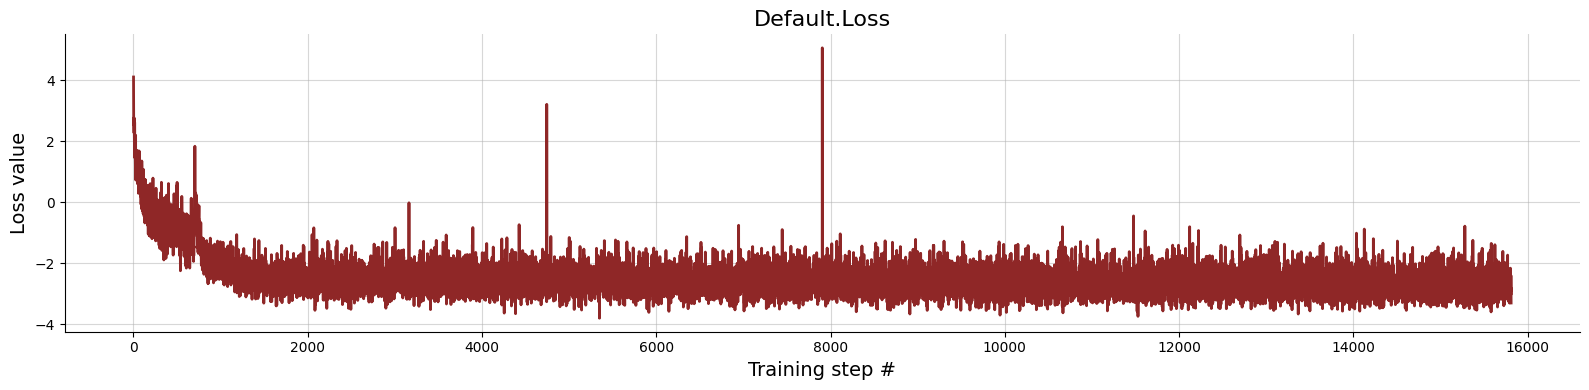

In [26]:
f = diag.plot_losses(h)

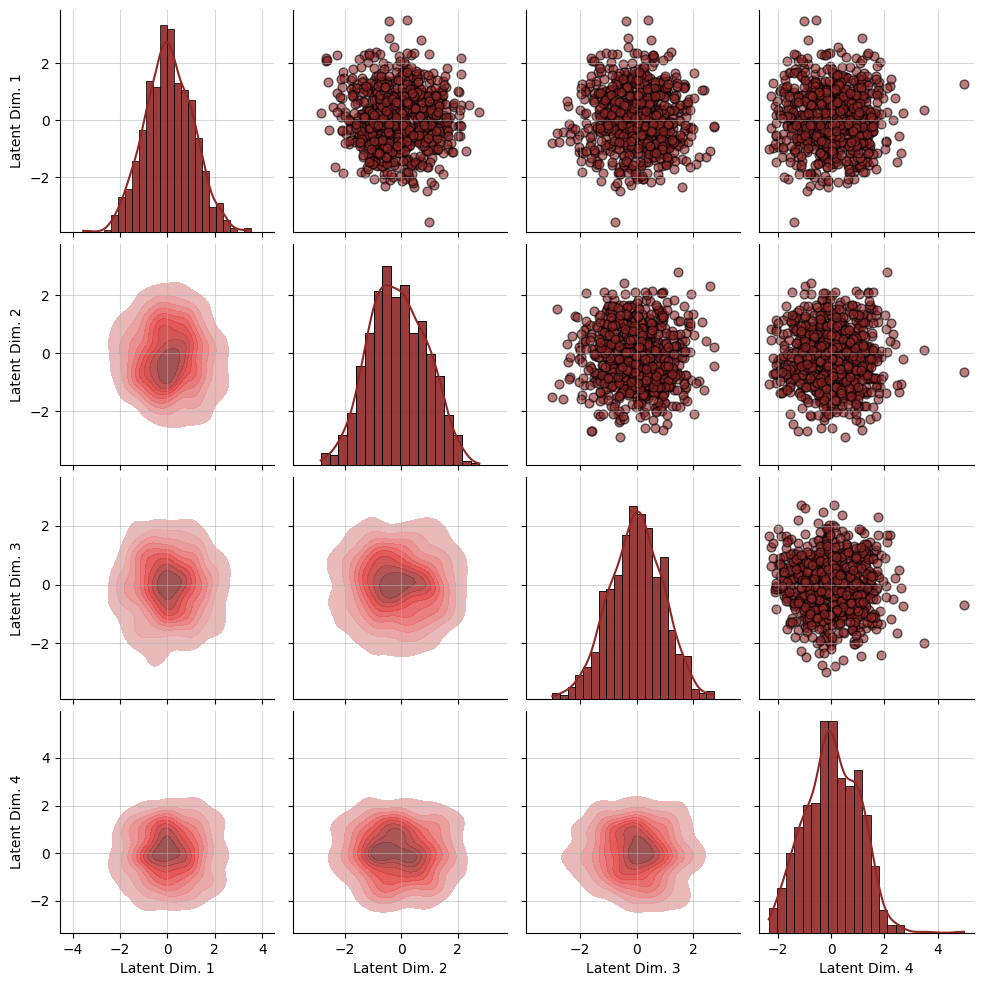

In [27]:
f = trainer.diagnose_latent2d()

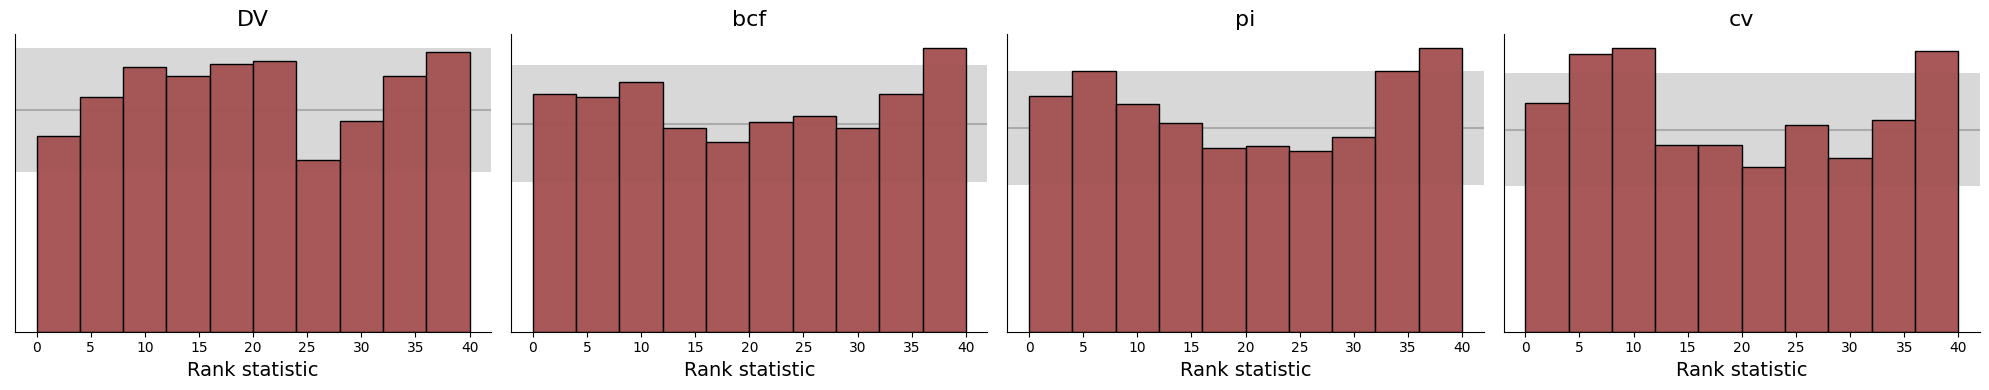

In [28]:
f = trainer.diagnose_sbc_histograms()

In [ ]:
# Generate some validation data
validation_sims = configure_input(model(batch_size=100))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=500)

# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims['parameters'])

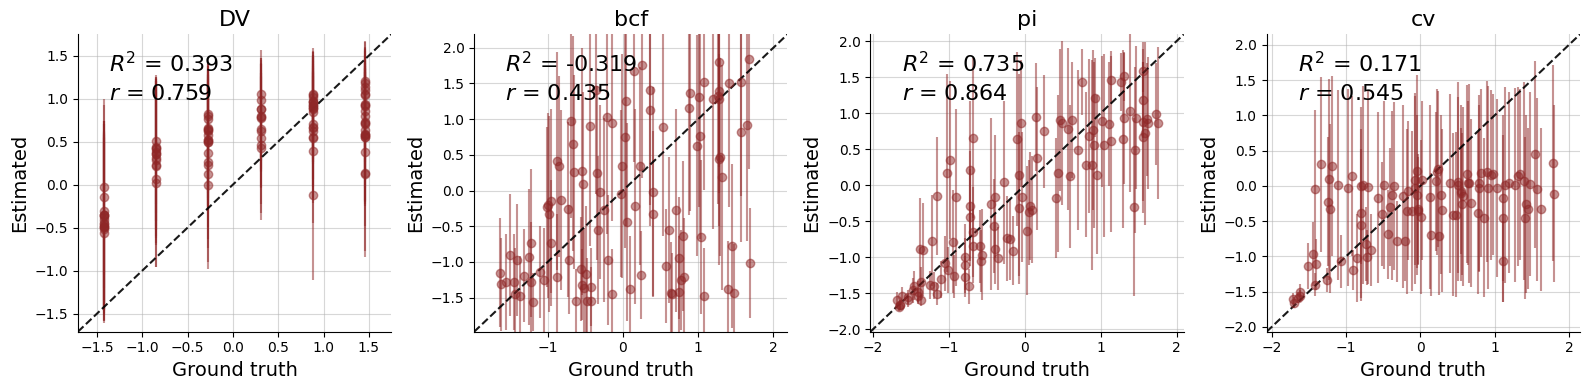

In [ ]:
f = diag.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)